<a href="https://colab.research.google.com/github/emilyswitzer/celeb-heights/blob/main/Improving_Celebs_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [ ]:
!unzip "/content/smallerwithpadding.zip" -d "/"

Archive:  /content/smallerwithpadding.zip
replace /content/train/162/Barbara Hershey.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip "/content/train.zip" -d "/a"

Archive:  /content/train.zip
   creating: /a/train/106/
  inflating: /a/train/106/Beetlejuice.jpg  
  inflating: /a/train/106/Billy Barty.jpg  
  inflating: /a/train/106/Danny Woodburn.jpg  
  inflating: /a/train/106/David Rappaport.jpg  
  inflating: /a/train/106/Deep Roy.jpg  
  inflating: /a/train/106/Dylan 'Hornswoggle' Postl.jpg  
  inflating: /a/train/106/Herve Villechaize.jpg  
  inflating: /a/train/106/Jason Acuna.jpg  
  inflating: /a/train/106/Jimmy Vee.jpg  
  inflating: /a/train/106/Kenny Baker.jpg  
  inflating: /a/train/106/Kiran Shah.jpg  
  inflating: /a/train/106/Leigh Gill.jpg  
  inflating: /a/train/106/Martin Klebba.jpg  
  inflating: /a/train/106/Meredith Eaton.jpg  
  inflating: /a/train/106/Michael J Anderson.jpg  
  inflating: /a/train/106/Peter Dinklage.jpg  
  inflating: /a/train/106/Phil Fondacaro.jpg  
  inflating: /a/train/106/Rusty Goffe.jpg  
  inflating: /a/train/106/Sam Humphrey.jpg  
  inflating: /a/train/106/Tony Cox.jpg  
  inflating: /a/train/106/Ve

In [ ]:
import pathlib
import glob
import cv2
#data_dir = "train/"
data_dir = "/a/train/"
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3216


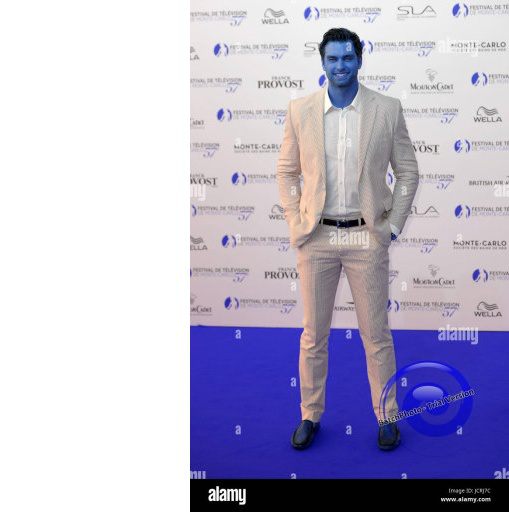

In [ ]:
person = list(data_dir.glob('191/*'))
PIL.Image.open(str(person[10]))


# Load data using a Keras utility


## Create a dataset

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
batch_size = 8
#img_height = 256
#img_width = 211

img_height = 512
img_width = 509

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),

  batch_size=batch_size)


Found 3216 files belonging to 68 classes.
Using 1930 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
 
  batch_size=batch_size)

Found 3216 files belonging to 68 classes.
Using 1286 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['106', '109', '111', '114', '116', '119', '121', '125', '127', '129', '130', '132', '139', '146', '147', '148', '149', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '177', '178', '179', '180', '181', '182', '183', '184', '185', '188', '190', '191', '192', '193', '194', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '81']


## Visualize the data



In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 512, 509, 3)
(8,)


The `image_batch` is a tensor of the shape `(32, 512, 268, 3)`. This is a batch of 32 images of shape `512x268x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


## Configure the dataset for performance

**Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
**Dataset.prefetch** overlaps data preprocessing and model execution while training.


In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. To keep input values small  standardize values to be in the `[0, 1]` range.

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# Create the model

The Sequential model consists of three convolution blocks (`Conv2D`) with a max pooling layer (`MaxPooling2D`) in each of them. There's a fully-connected layer (`Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). 

## Compile the model

## Overfitting

## Data augmentation

Data augmentationtakes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

Implement data augmentation using the following Keras preprocessing layers: `RandomFlip`, `RandomRotation`, and `RandomZoom`.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

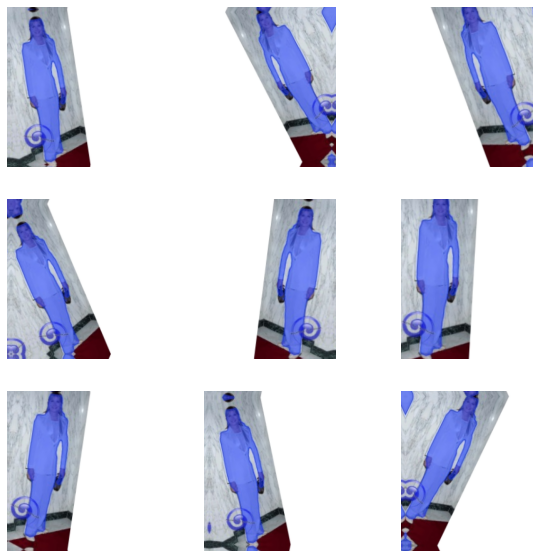

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Dropout randomly drops out a number of output units from the layer during the training process. Dropout takes a fractional number as its input value using 
`Dropout`

#Create the model with Overfitting Solutions

In [ ]:
num_classes = len(class_names)


model = Sequential([
 # data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  #layers.Dense(num_classes),
  layers.Dense(1)
  
])

In [ ]:
num_classes = len(class_names)


model = Sequential([
  #data_augmentation,
  layers.Rescaling(1./255, input_shape=(256, 211, 3)),
  layers.Conv2D(32, 3,padding='same', activation='relu'),
  layers.Conv2D(32, 3,padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3,padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3,padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1024 ,activation="relu"),
  layers.Dense(512 ,activation="relu"),
  layers.Dense(num_classes),
  layers.Dense(activation='softmax')
])

In [ ]:
checkpoint = ModelCheckpoint('model.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 

x = list/ array of images
y - list/array of number (height)

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
             metrics=['accuracy'])

In [ ]:
#model.summary()

In [ ]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 150
history = model.fit(
  train_ds,
  validation_data=val_ds,
 
 # callbacks=[checkpoint],
  epochs=epochs
)

Epoch 1/150
242/242 [==============================] - 539s 2s/step - loss: 381.8198 - accuracy: 0.0078 - val_loss: 306.8647 - val_accuracy: 0.0062
Epoch 2/150
242/242 [==============================] - 530s 2s/step - loss: 262.3592 - accuracy: 0.0078 - val_loss: 253.9663 - val_accuracy: 0.0062
Epoch 3/150
242/242 [==============================] - 509s 2s/step - loss: 280.3830 - accuracy: 0.0078 - val_loss: 342.2874 - val_accuracy: 0.0062
Epoch 4/150
242/242 [==============================] - 506s 2s/step - loss: 216.2112 - accuracy: 0.0078 - val_loss: 183.5860 - val_accuracy: 0.0070
Epoch 5/150
242/242 [==============================] - 509s 2s/step - loss: 130.0988 - accuracy: 0.0073 - val_loss: 131.0552 - val_accuracy: 0.0062
Epoch 6/150
242/242 [==============================] - 503s 2s/step - loss: 87.7214 - accuracy: 0.0078 - val_loss: 156.9873 - val_accuracy: 0.0062
Epoch 7/150
242/242 [==============================] - 500s 2s/step - loss: 67.8447 - accuracy: 0.0078 - val_loss

## Visualize training results


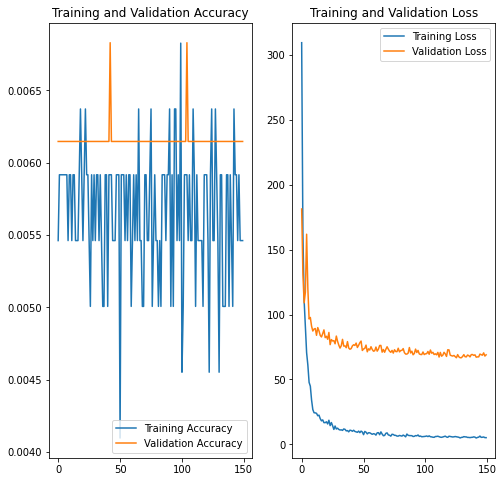

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on unseen data

In [ ]:
!unzip "/content/unseen2.zip" -d "/content/unseen"

In [ ]:
#RESIZE IMAGE
import glob
import cv2 
import os
from os.path import basename
from imutils import paths
import imutils
import argparse
maxwidth = 196

path = "/content/unseen/*"
newpath = "/content/unseen/"
for file in glob.glob(path):
 



   img = cv2.imread(file)[:,:,::-1]
   h, w, c = img.shape
 
   fil = basename(file)
   filname = os.path.splitext(fil)[0]
   bordersize = maxwidth-w
   color = [255, 255, 255]
   bordered_img=cv2.copyMakeBorder(img, 
                                top=0,bottom=0, 
                                left=bordersize, right=0, 
                                borderType=cv2.BORDER_CONSTANT, 
                                value=[255,255,255])

   cv2.imwrite(newpath+filname+'.jpg', bordered_img)


In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('/content/unseen/content/unseen2/202.jpg')
imgplot = plt.imshow(img)
plt.show()
sunflower_path = '/content/unseen/content/unseen2/202.jpg'

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])




print(
    "The person is {:.2f} percent {} cm "
    .format(100 * np.max(score),class_names[np.argmax(score)])
)

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)